The BG base line is not found for 176.0 and we used 80.0001
Participant= 38A Modeling method= SVM Accuracy= 87.0 Sensitivity= 48.0 Specificity= 94.0
------------------------------------------------
The BG base line is not found for 200.0 and we used 80.0001
Participant= 38B Modeling method= SVM Accuracy= 91.0 Sensitivity= 9.0 Specificity= 100.0
------------------------------------------------
The BG base line is not found for 220.0 and we used 80.0001
Participant= 38C Modeling method= SVM Accuracy= 85.0 Sensitivity= 46.0 Specificity= 92.0
------------------------------------------------
Participant= 38D Modeling method= SVM Accuracy= 91.0 Sensitivity= 15.0 Specificity= 99.0
------------------------------------------------
Participant= 38E Modeling method= SVM Accuracy= 89.0 Sensitivity= 17.0 Specificity= 99.0
------------------------------------------------
Participant= 38F Modeling method= SVM Accuracy= 90.0 Sensitivity= 15.0 Specificity= 98.0
-----------------------------------------

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


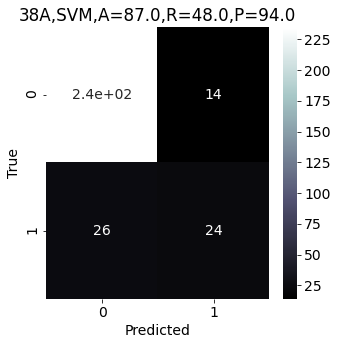

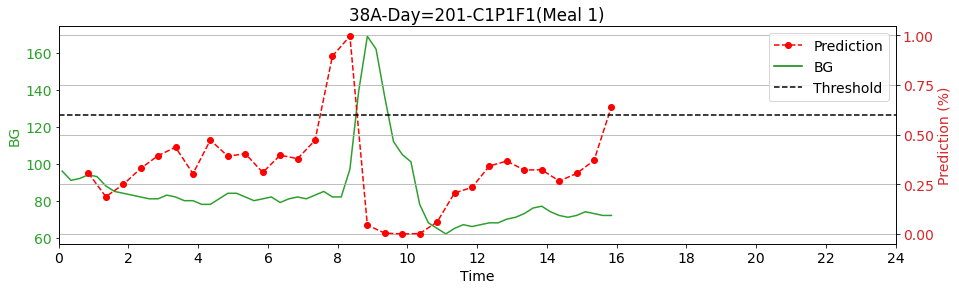

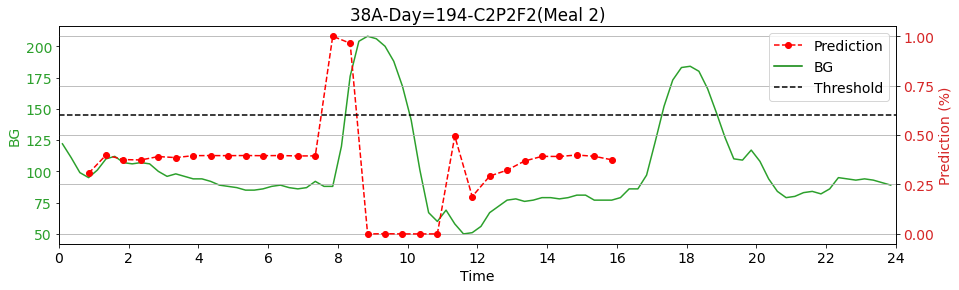

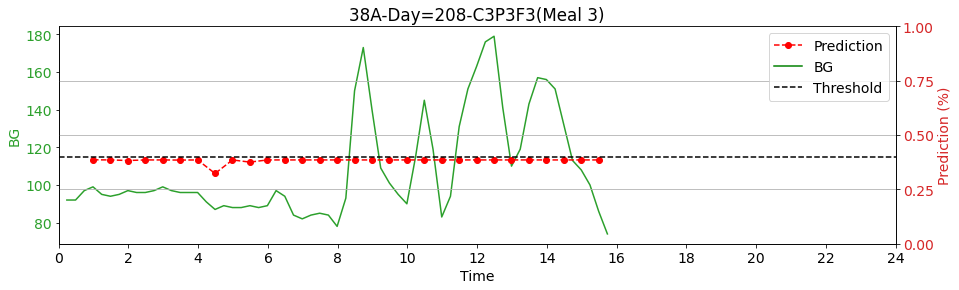

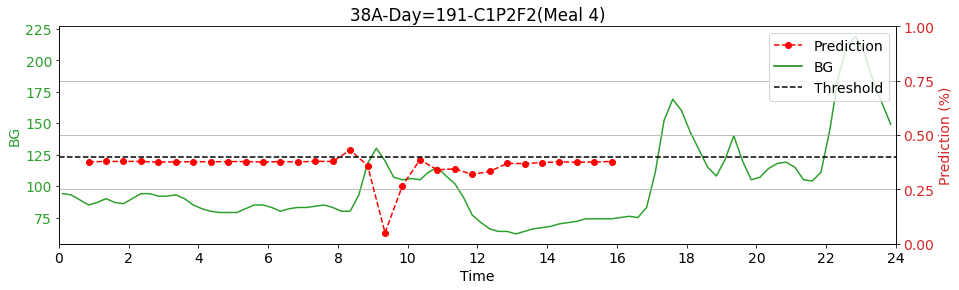

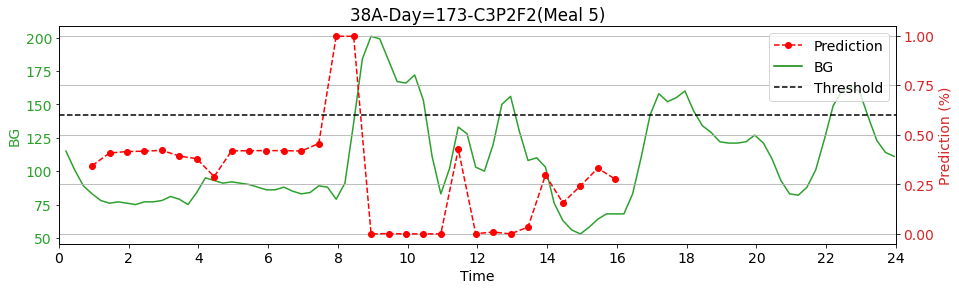

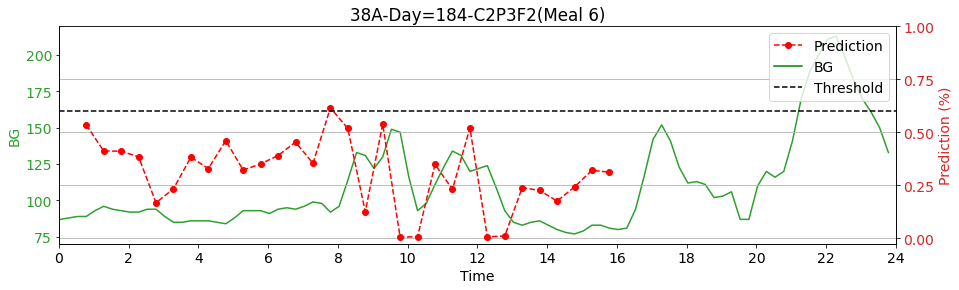

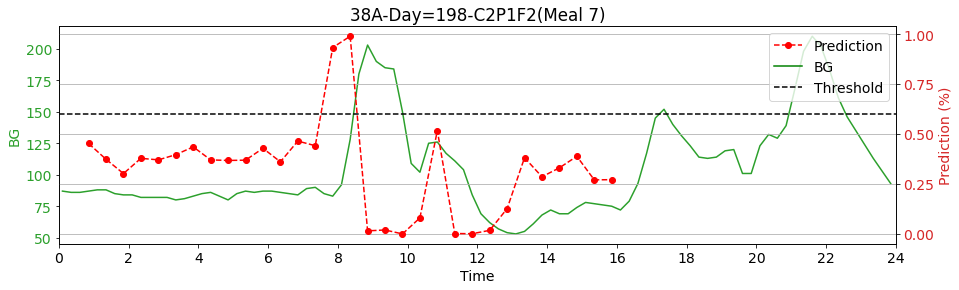

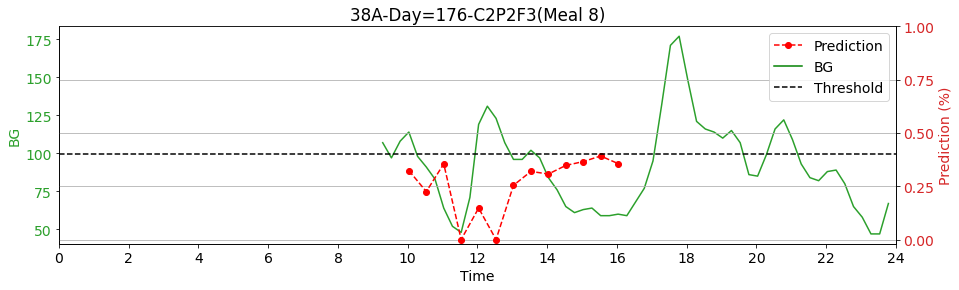

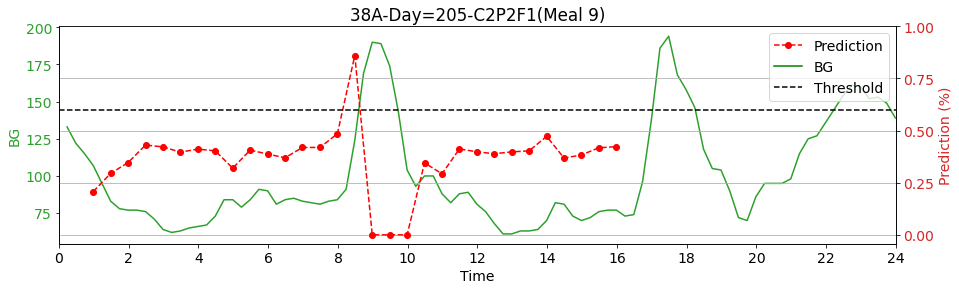

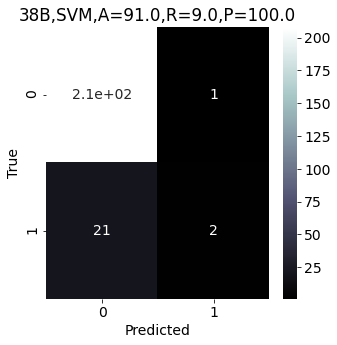

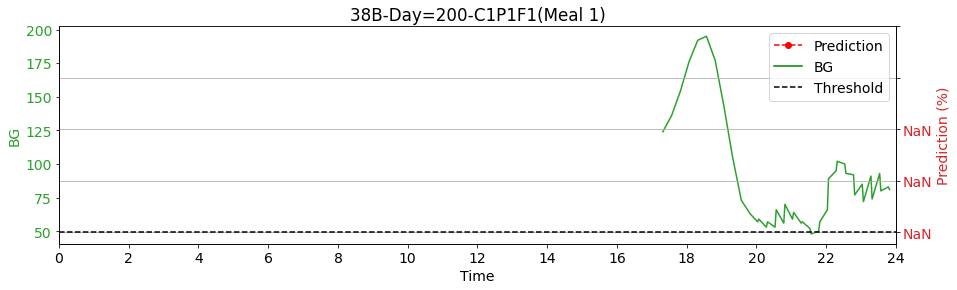

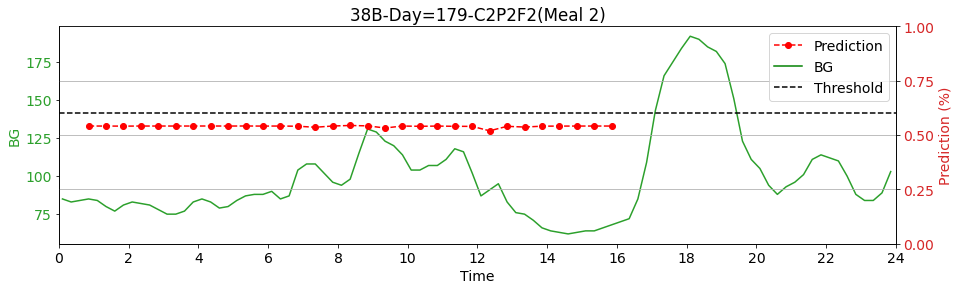

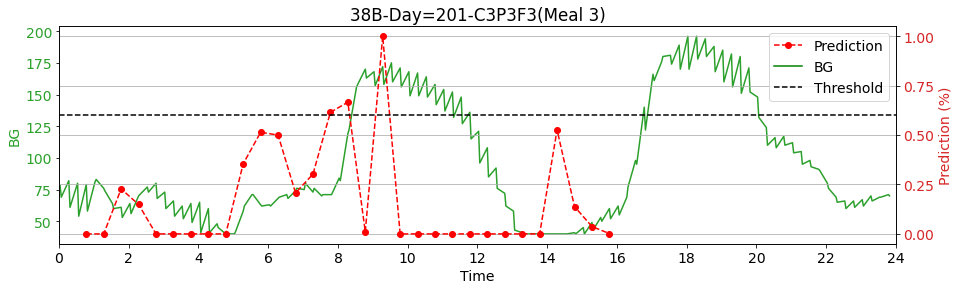

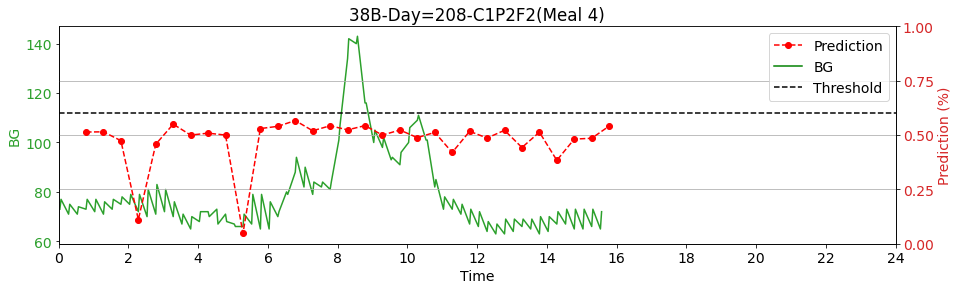

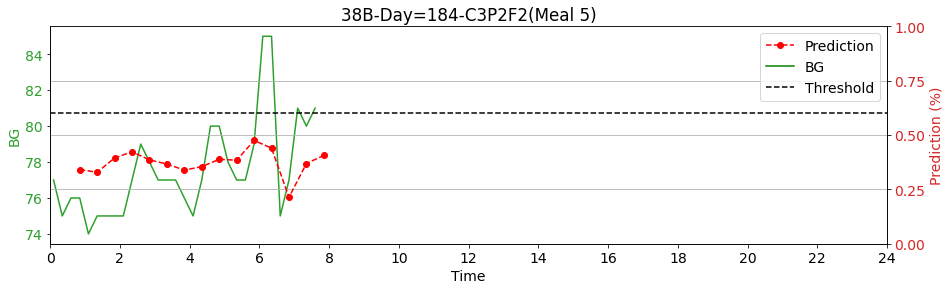

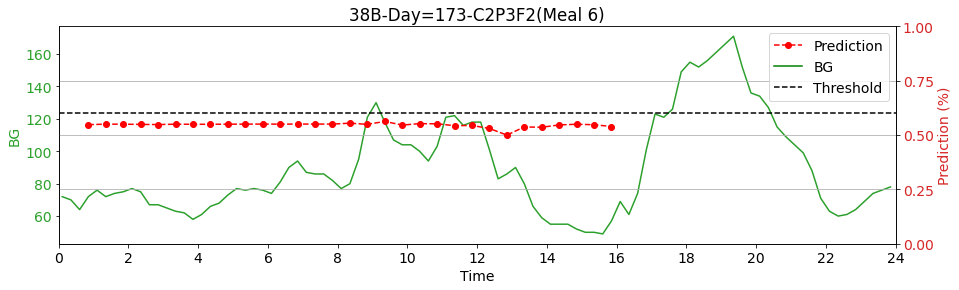

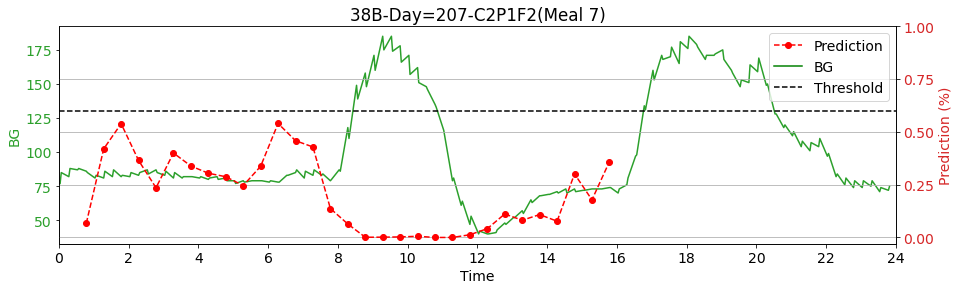

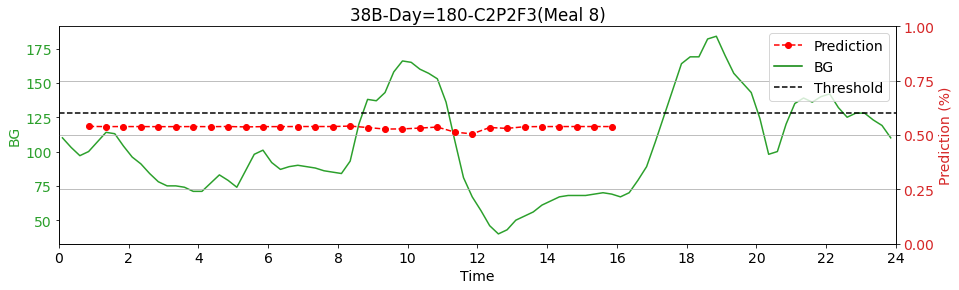

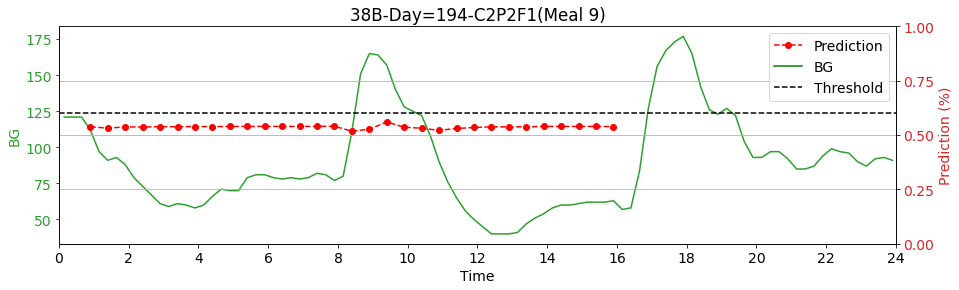

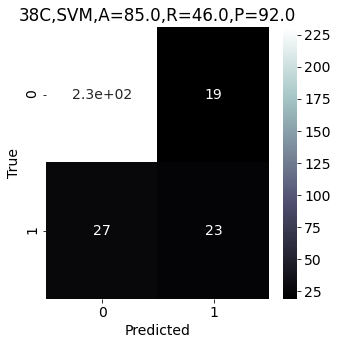

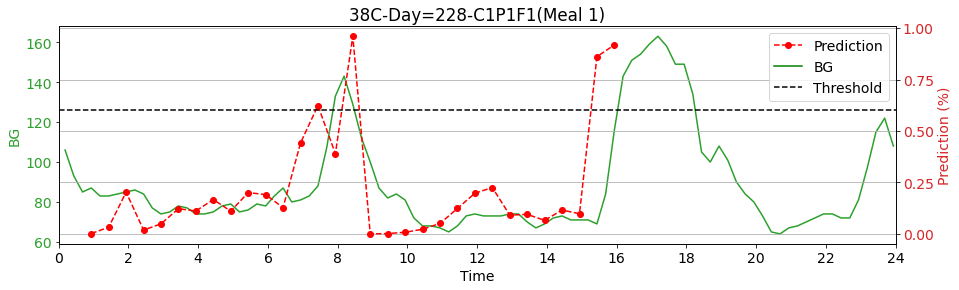

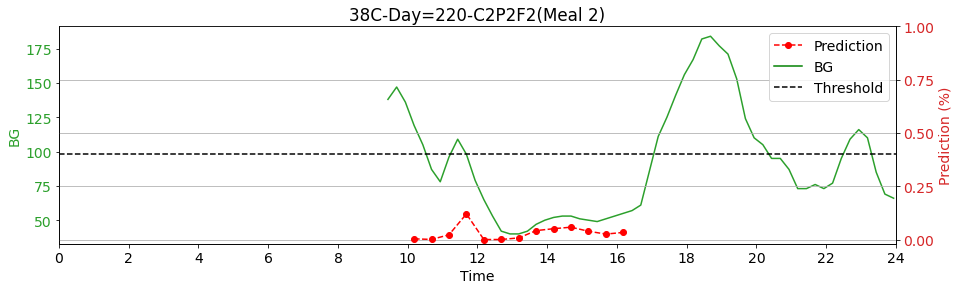

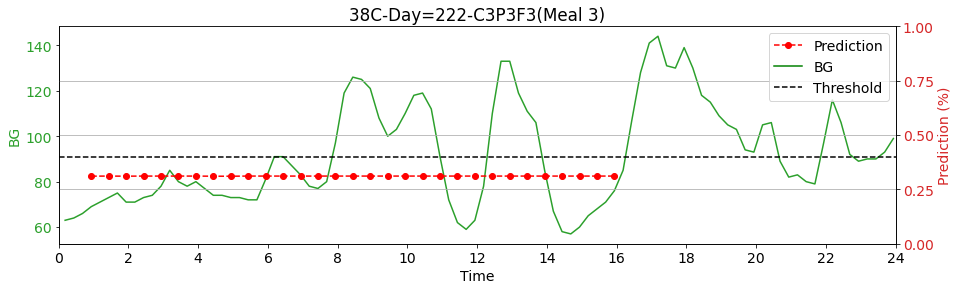

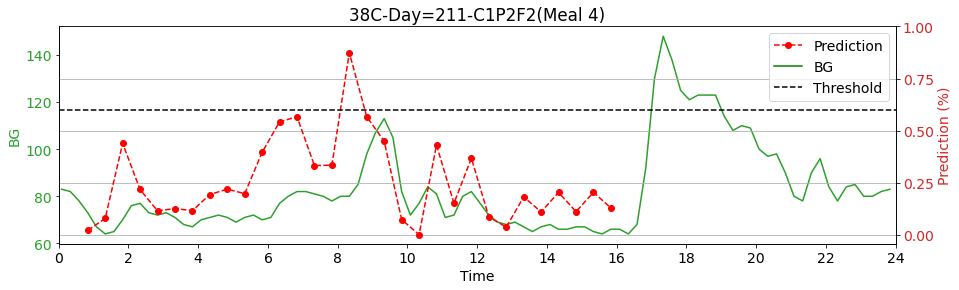

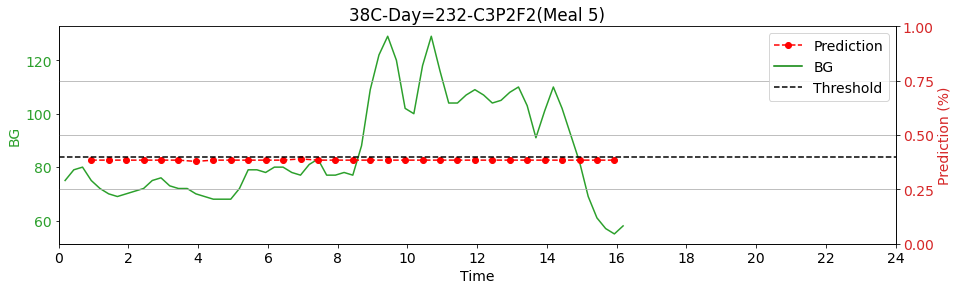

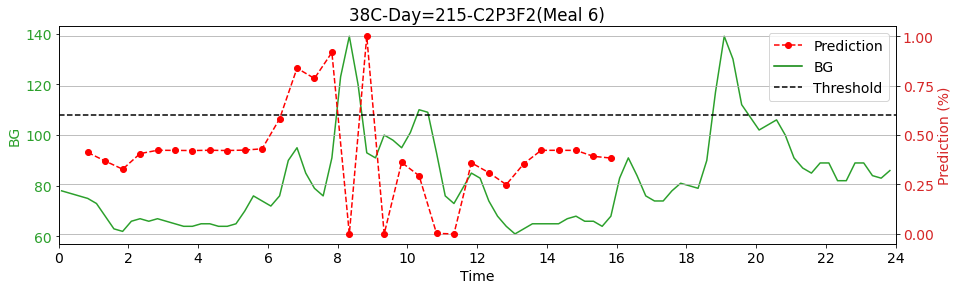

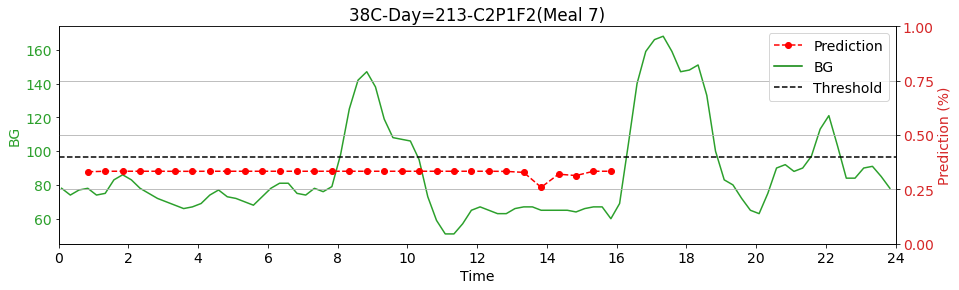

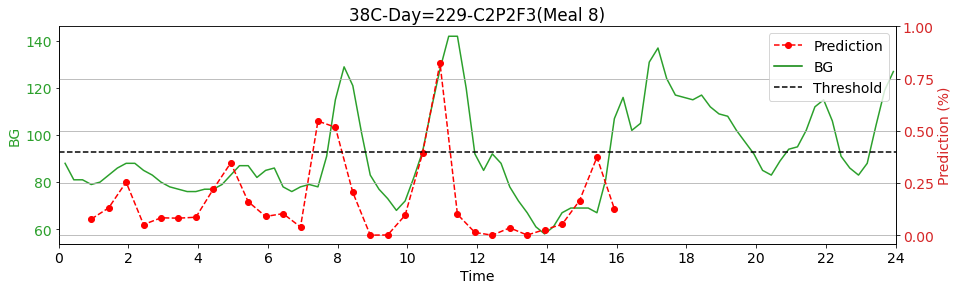

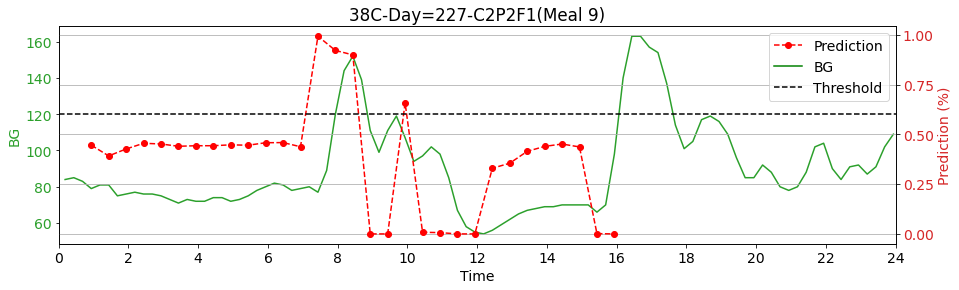

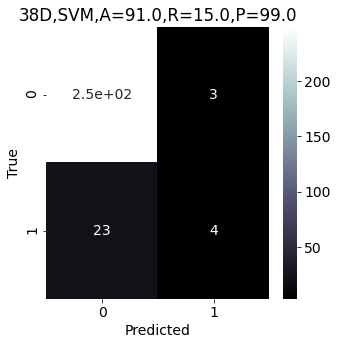

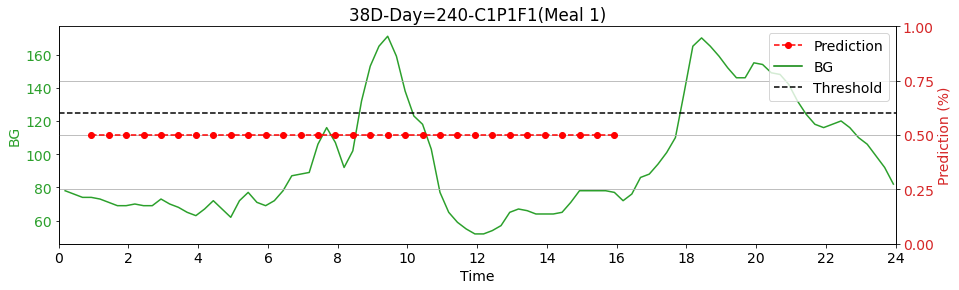

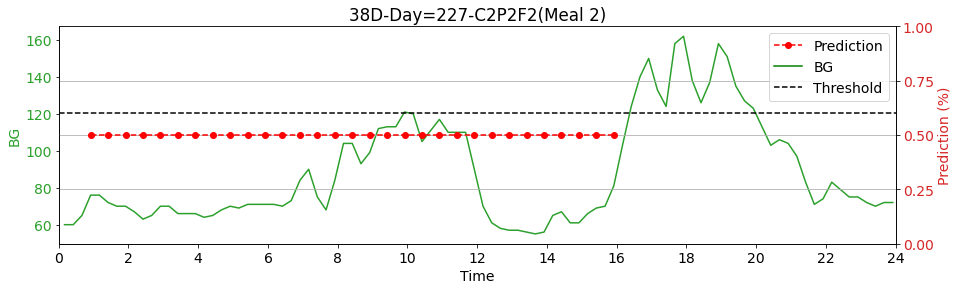

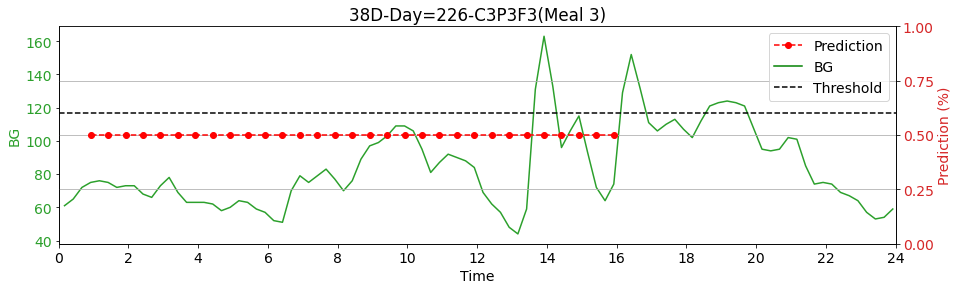

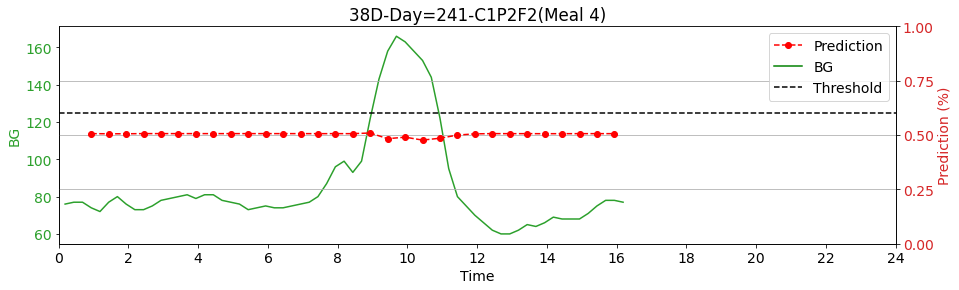

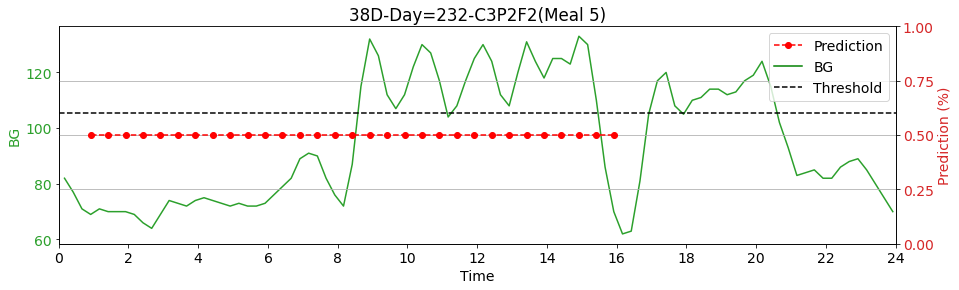

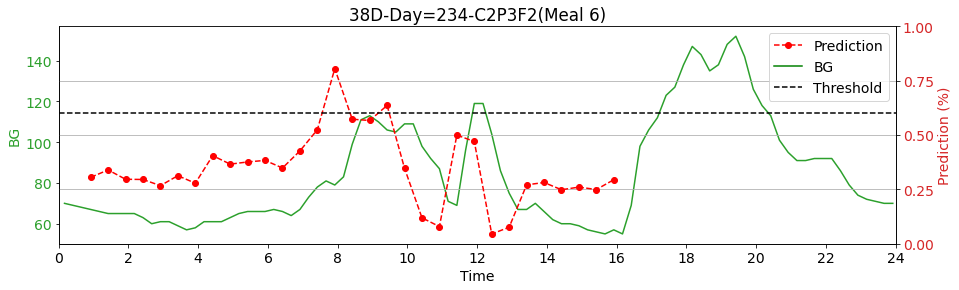

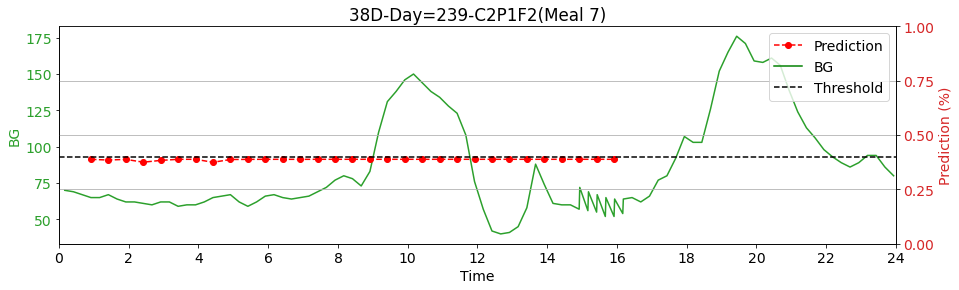

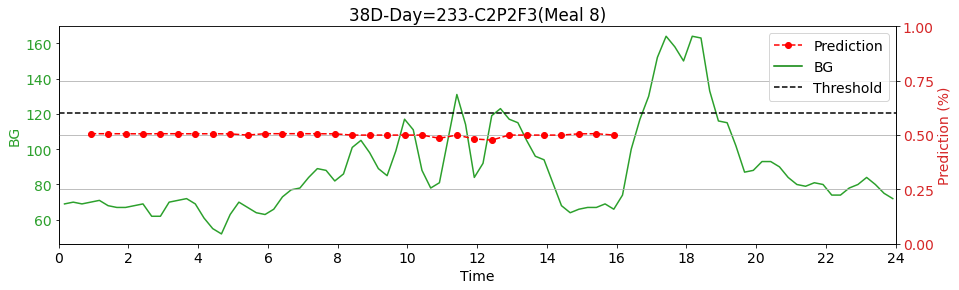

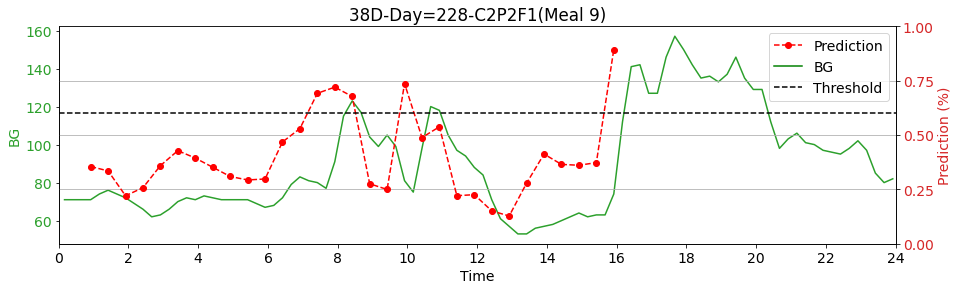

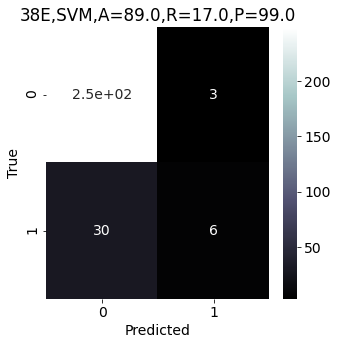

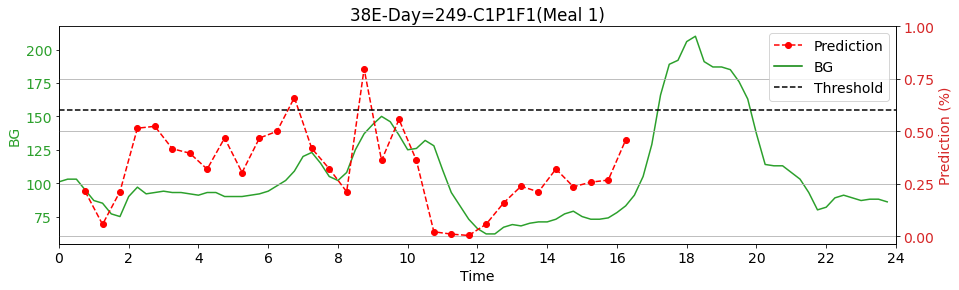

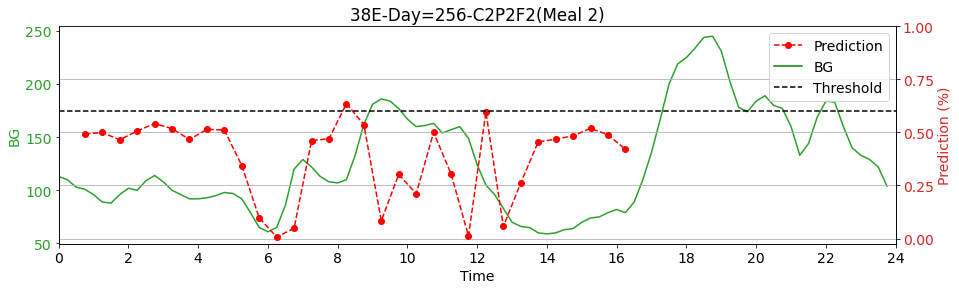

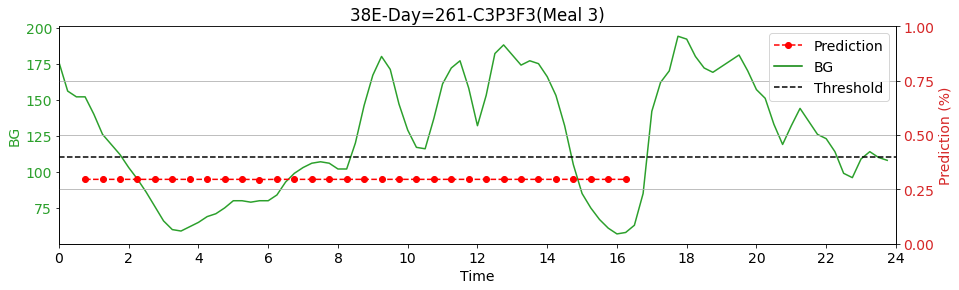

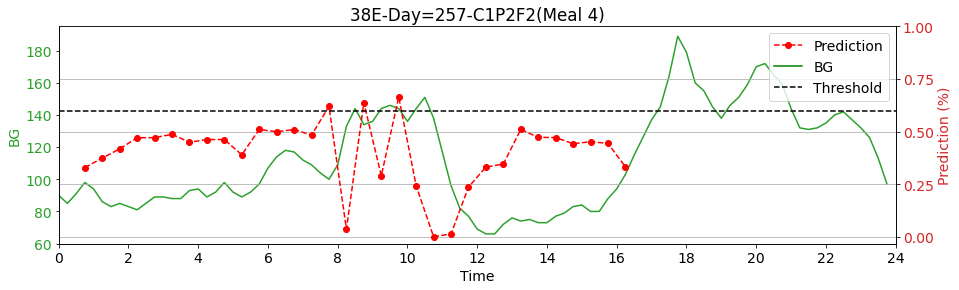

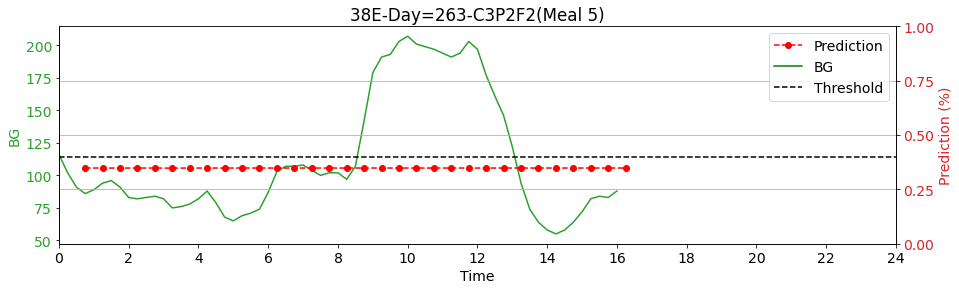

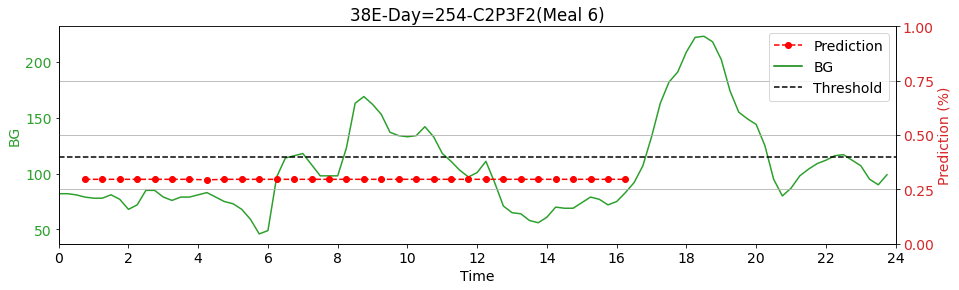

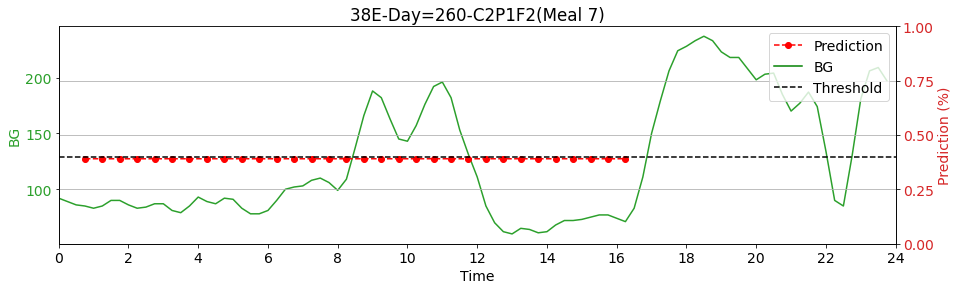

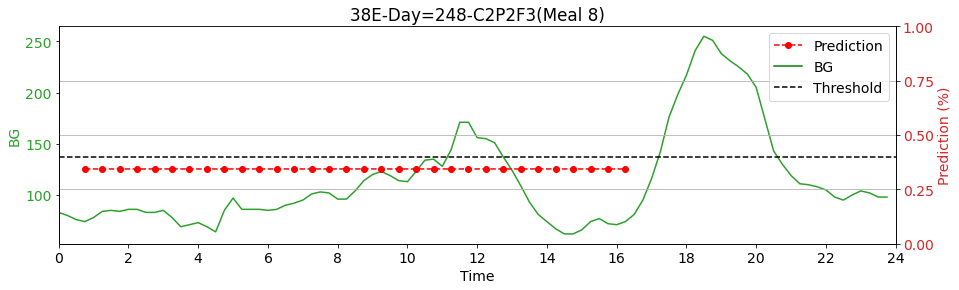

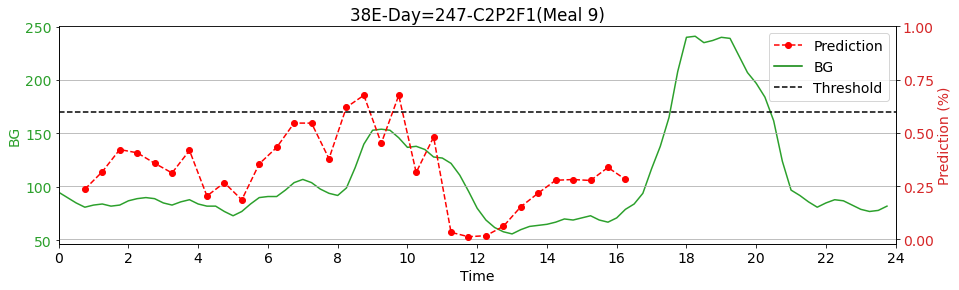

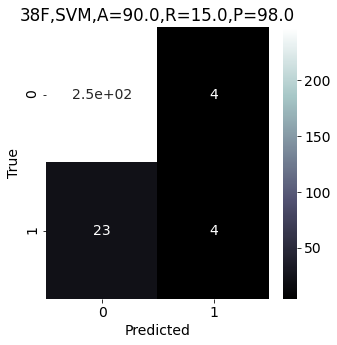

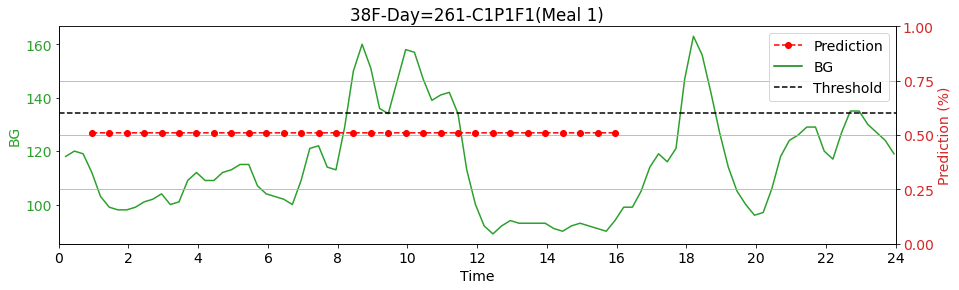

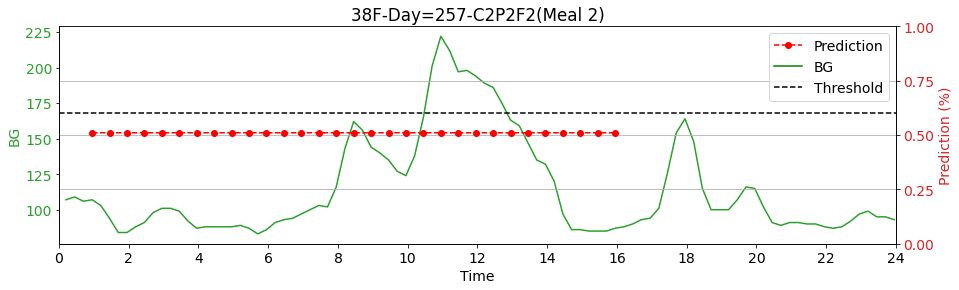

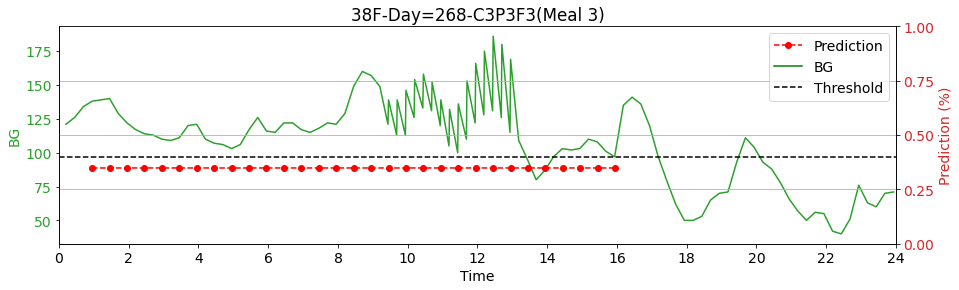

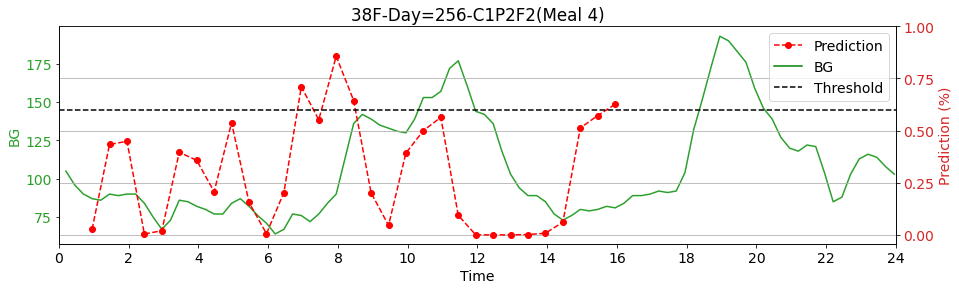

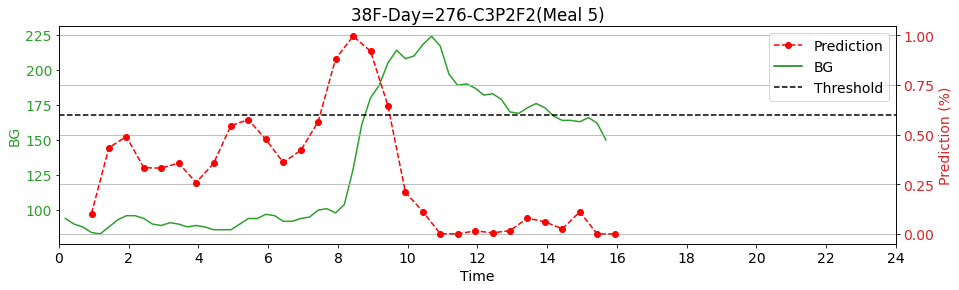

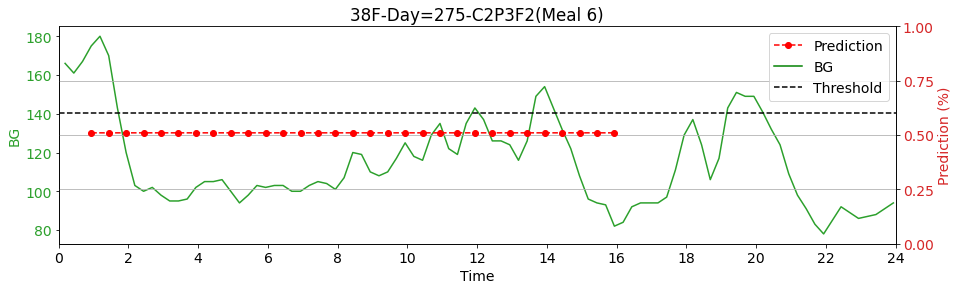

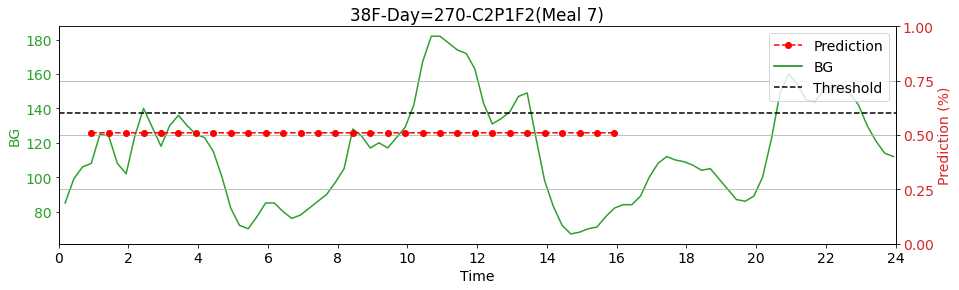

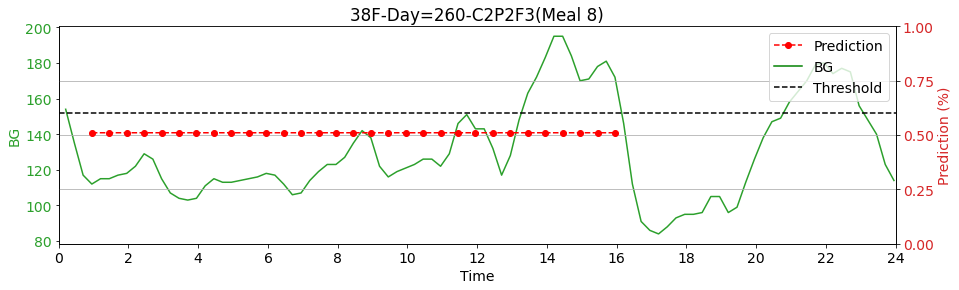

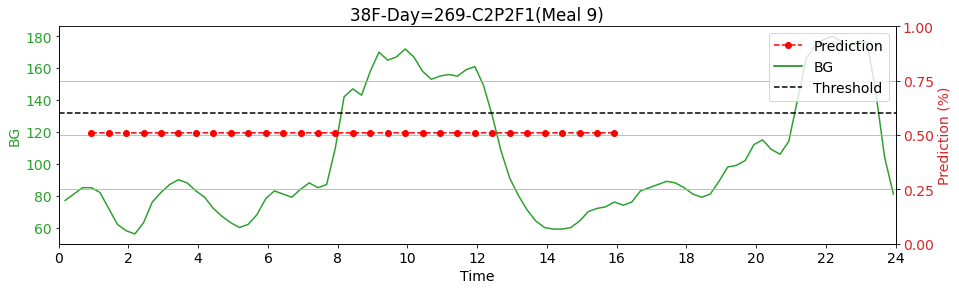

In [1]:
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.font_manager
from scipy.integrate import simps
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'normal','size': 14}
plt.rc('font', **font)
plt.rc('figure', titlesize=14)

if 'imac' in os.getcwd():
    macFlag=True
else:
    macFlag=False

if not macFlag:
    rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
    rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
    rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
else:
    rootAddress= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38"
    rootAddressAllData='/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Selected-38'
    rootAddressSanitized='/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Selected-38/TestDays_'

#Setting the testdays for each participant, the days are in order. Meaning that the first day is Meal 1 and so on.
testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,6),datetime(2018,9,13),datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,20),datetime(2018,9,11),datetime(2018,9,17),datetime(2018,9,5),datetime(2018,9,4)],
           [datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,25),datetime(2018,9,13),datetime(2018,10,3),datetime(2018,10,2),datetime(2018,9,27),datetime(2018,9,17),datetime(2018,9,26)],
           [datetime(2018,10,4),datetime(2018,10,9),datetime(2018,9,25),datetime(2018,10,11),datetime(2018,9,26),datetime(2018,10,3),datetime(2018,10,10),datetime(2018,9,27),datetime(2018,10,2)]
           ]).astype(datetime)
#Convert the datetime to day of year and the second element is the meal number
testDaysMealNumbers=np.zeros((7,9,2))
for i in range(7):
    for j in range(9):
        tempDay=testDays[i,j]
        testDaysMealNumbers[i,j,0]=tempDay.timetuple().tm_yday
        testDaysMealNumbers[i,j,1]=j

#Separating the test days from normal ones and forming the sanitized files
def dataSanitizer(rootAddressAllData,rootAddressSanitized):
    os.chdir(rootAddressAllData)
    patientName=['38A','38B','38C','38D','38E','38F','38H']
    fileNames=os.listdir()

    for fileName in fileNames:
        for counter in range(7):
            if patientName[counter] in fileName:
                currentPatient=counter
                break
        print(fileName)
        myDf=pd.read_csv(fileName)
        for myColumn in myDf.columns:
            if myColumn not in ['time','BG','Participant']:
                del myDf[myColumn]
        myDf=myDf.dropna()
        myDf=myDf.drop_duplicates(subset=['time'], keep='last')
        myDf['time']= pd.to_datetime(myDf['time'])

        myDf.insert(3,"StandardTest",0)
        for rowCounter in range(0,len(myDf)):
            for counter in range(0,9):
                if myDf.iloc[rowCounter,1].date()==testDays[currentPatient][counter].date():
                    myDf.iloc[rowCounter,3]=counter+1
                    break

        myDf=myDf[myDf.StandardTest > 0]
        myFileAddress=rootAddressSanitized+patientName[currentPatient]+'.csv'
        myDf.to_csv(myFileAddress,index = False)

# dataSanitizer(rootAddressAllData,rootAddressSanitized)

def saveModel(modelingMethod,modelBest,threshBest,patientName,testDay):
    if not macFlag:
        modelFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    else:
        modelFile= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    pickle.dump(modelBest, open(modelFile, "wb"))
    with open(parameterFile, 'wb') as file:
        np.save(file,threshBest)

def loadModel(modelingMethod,patientName,testDay):
    modelBest="NaN"
    threshBest="NaN"
    if not macFlag:
        modelFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    else:
        modelFile= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    modelExistFlag=os.path.isfile(modelFile) and os.path.isfile(parameterFile)
    if modelExistFlag:
        with open(modelFile, 'rb') as file:
            modelBest = pickle.load(file)

        with open(parameterFile, 'rb') as file:
            threshBest=np.load(file)

    return modelBest,threshBest,modelExistFlag

#Setting Logistic Regression algorithm and testing all hyper-parameters
def STMI_logistic_regression(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold_counter in np.arange(0.4, 0.8, 0.2):
        for C in [0.5,1,1.5,2]:
            clf = LogisticRegression(C=C,max_iter=10000)
            clf.fit(trainData, trainLabels)
            slidingWindowPrediction = clf.predict_proba(testData)
            slidingWindowPrediction = slidingWindowPrediction[:, 1]
            slidingWindowPrediction[slidingWindowPrediction >= threshold_counter] = 1
            slidingWindowPrediction[slidingWindowPrediction < threshold_counter] = 0

            confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
            accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

            if accuracy > accuracyBest:
                accuracyBest = accuracy
                confMatrixBest = confMatrix
                threshBest = threshold_counter
                modelBest = clf

    features = "NaN"
    saveModel('LR',modelBest,threshBest,patientName,testDay)
    return modelBest, confMatrixBest,threshBest, features

#Setting SVM algorithm and testing all hyper-parameters
def STMI_SVM(trainData,testData,trainLabels,testLabels,patientName,testDay):
    kernels = ['linear', 'poly', 'rbf']
    accuracyBest=-1
    confMatrixBest=[]
    for kernel in kernels:
        for threshold in np.arange(0.4, 0.8, 0.2):
            for C in np.arange(0.5, 2, 0.5):
                for gamma in np.arange(0.05, 0.15, 0.05):
                    clf = SVC(kernel=kernel,gamma=gamma,probability=True,C=C)
                    clf.fit(trainData, trainLabels)
                    slidingWindowPrediction = clf.predict_proba(testData)
                    slidingWindowPrediction = slidingWindowPrediction[:, 1]
                    slidingWindowPrediction[slidingWindowPrediction >= threshold] = 1
                    slidingWindowPrediction[slidingWindowPrediction < threshold] = 0

                    confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                    accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                    if accuracy > accuracyBest:
                        modelBest = clf
                        threshBest = threshold

                        confMatrixBest = confMatrix
                        accuracyBest = accuracy

                    if kernel=='linear':
                        break

    features = "NaN"
    saveModel('SVM',modelBest,threshBest,patientName,testDay)
    return modelBest,confMatrixBest, threshBest, features

#Setting Random Forest algorithm and testing all hyper-parameters
def STMI_random_forest(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.1):
        for treeNum in np.arange(3,10):
            for maxDepth in np.arange(3,10):
                clf=RandomForestClassifier(n_estimators=treeNum,criterion='entropy',random_state=0,max_depth=maxDepth)
                clf.fit(trainData,trainLabels)
                slidingWindowPrediction=clf.predict_proba(testData)
                slidingWindowPrediction=slidingWindowPrediction[:,1]
                slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
                slidingWindowPrediction[slidingWindowPrediction<threshold]=0

                confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                if accuracy>accuracyBest:
                    confMatrixBest=confMatrix
                    threshBest=threshold
                    accuracyBest=accuracy
                    modelBest=clf

    features=np.round(modelBest.feature_importances_*100,1)
    saveModel('RF',modelBest,threshBest,patientName,testDay)
    return modelBest,confMatrixBest,threshBest,features

#Setting XGBoost algorithm and testing all hyper-parameters
def STMI_XGBoost(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.2):
        for eta in np.arange(0.05,0.50,0.05):
            for maxDepth in np.arange(3,10):
                clf = XGBClassifier(eta=eta,max_depth=maxDepth,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
                clf.fit(trainData, trainLabels)
                slidingWindowPrediction = clf.predict_proba(testData)
                slidingWindowPrediction=slidingWindowPrediction[:,1]
                slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
                slidingWindowPrediction[slidingWindowPrediction<threshold]=0

                confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                if accuracy>accuracyBest:
                    confMatrixBest=confMatrix
                    accuracyBest=accuracy
                    threshBest=threshold
                    modelBest=clf

    features=np.round(modelBest.feature_importances_*100,1)
    saveModel('XG',modelBest,threshBest,patientName,testDay)

    return modelBest,confMatrixBest,threshBest,features

#Finding the fasting blood glucose value for each day
def fastingBGFinder(query,currentDay):
    fastingBG=80.0001
    fastingQuery=query[query['Time']>=3]
    fastingQuery=fastingQuery[fastingQuery['Time']<=6]

    if(not np.isnan(fastingQuery.BG.mean())):
        fastingBG=fastingQuery.BG.mean()
    else:
        print("The BG base line is not found for",currentDay,"and we used 80.0001")
    return fastingBG

#Calculating the statistics for each sliding window
def statCalculator(query,baseLine):
    integralValue=simps(query.iloc[:,3]-baseLine,x=query.iloc[:,2])

    maxSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxSlopeValue=np.max(maxSlopeValue)

    minSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minSlopeValue=np.min(minSlopeValue)

    pointNum=len(query)-1
    if query.iloc[int(pointNum/2),2]==query.iloc[0,2]:
        print(query)
        sys.exit('The window qurery is not big enough. The minimum window duration should be more than 1 hour')

    firstHalfSlope=query.iloc[int(pointNum/2),3]-query.iloc[0,3]
    firstHalfSlope/=query.iloc[int(pointNum/2),2]-query.iloc[0,2]

    secondHalfSlope=query.iloc[pointNum,3]-query.iloc[int(pointNum/2),3]
    secondHalfSlope/=query.iloc[pointNum,2]-query.iloc[int(pointNum/2),2]

    maxConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxConcavityValue=np.gradient(maxConcavityValue,query.iloc[:,2])
    maxConcavityValue=np.max(maxConcavityValue)

    minConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minConcavityValue=np.gradient(minConcavityValue,query.iloc[:,2])
    minConcavityValue=np.min(minConcavityValue)

    meanValue=query['BG'].mean()-baseLine
    stdValue=query['BG'].std()
    minValue=query['BG'].min()-baseLine
    maxValue=query['BG'].max()-baseLine

    return meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,firstHalfSlope,secondHalfSlope,integralValue,minConcavityValue,maxConcavityValue

#Chopping the data into daily values and forming the slidingWindow
def slidingWindowMaker(testMealNum,rawData):
    testMealNum=testMealNum[:,0]
    slidingWindow=[]
    slidingWindowLabel=[]
    for counter in range(len(testMealNum)):
        currentDay=testMealNum[counter]
        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while len(windowQuery)>=(timeWindow*4/2):
            if endTime>17:
                break #after 4PM the participants go home and they don't hold the criteria anymore
            if startTime<=breakfastTime and endTime>=breakfastTime:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            slidingWindow.append(statInfo)
            slidingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    slidingWindow=np.array(slidingWindow,dtype=float)
    slidingWindowLabel=np.array(slidingWindowLabel,dtype=int)
    return slidingWindow,slidingWindowLabel

#Reading the CSV for each participant and calculating the day of year and time (decimal format)
def csvReader(csvAddress):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)
    return allDays,rawData

#Balacing the slidingWindow data using SMOTE
def dataBalancer(slidingWindow,slidingWindowLabel):
    oversample = SMOTE()
    slidingWindowSMOTE, slidingWindowLabelSMOTE = oversample.fit_resample(slidingWindow, slidingWindowLabel)
    return slidingWindowSMOTE, slidingWindowLabelSMOTE

#Plotting the BG time-series and the prediction probability on top of that
def windowVisualizer(rawData,modelingMethod,testMealNum,patientName,slidingWindow,slidingWindowLabel,startTime,endTime,days):
    mealContent=['C1P1F1','C2P2F2','C3P3F3',
                 'C1P2F2','C3P2F2','C2P3F2',
                 'C2P1F2','C2P2F3','C2P2F1']

    for dayCounter in range(len(testMealNum)):
        testDay=testMealNum[dayCounter,0]
        testDay=int(testDay)

        modelBest,threshBest,modelExistFlag=loadModel(modelingMethod,patientName,testDay)

        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==testDay]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 25, 2))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(slidingWindow.shape[0]):
            if days[counter]==testDay:
                tempData.append(slidingWindow[counter,:])
                tempLabel.append(slidingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        ax2 = ax1.twinx()
        if modelExistFlag:
            if modelingMethod=='XG' or modelingMethod=='RF' or modelingMethod=='SVM':
                tempPred=modelBest.predict_proba(tempData)
                tempPred=tempPred[:,1]
                # tempPred[tempPred>=threshBest]=1
                # tempPred[tempPred<threshBest]=0

            if modelingMethod=='LR':
                tempPred=modelBest.predict(tempData)
            ax2.plot(np.mean( np.array([tempStart,tempEnd]),axis=0),tempPred,linestyle='--', marker='o', color='r')

        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Prediction')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.plot([0,24],[threshBest,threshBest],linestyle='--', color='black',label='Threshold')
        ax2.legend(loc=1)

        color='tab:red'
        ax2.set_ylabel('Prediction (%)', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,0.25,0.50,0.75,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 25, 2))

        plt.title(patientName+"-Day="+str(testDay)+"-"+mealContent[dayCounter]+
                  "(Meal "+str(dayCounter+1)+")",color='black')

        plt.grid()
        plt.show()

#Calling the model (Random Forest, XGBoost, Support Vector Machine, Logistic Regression) and returning the model details
# to the main function
def modelTrainer(modelingMethod,trainData,testData,trainLabel,testLabel,patientName,testDay):
    if modelingMethod=='RF':
        modelResult=STMI_random_forest(trainData,testData,trainLabel,testLabel,patientName,testDay)
    if modelingMethod=='XG':
        modelResult=STMI_XGBoost(trainData,testData,trainLabel,testLabel,patientName,testDay)
    if modelingMethod == 'LR':
        modelResult = STMI_logistic_regression(trainData, testData, trainLabel, testLabel, patientName,testDay)
    if modelingMethod == 'SVM':
        modelResult = STMI_SVM(trainData, testData, trainLabel, testLabel, patientName,testDay)
    return modelResult

#reporting the importance of the statistical features for RF and XG (LR and SVM do not have this option)
def featureInterpretor(featureImportance):
    featureImportance=np.round(featureImportance,1)
    feat_labels = ['Average','STD','Min','Max','Min Slope', 'Max Slope','1st half slope','2nd half slope','Integral Value','Min Concavity','Max Concavity']
    print("The importance of each feature is shown below (the averaged value of all cases)")
    for feature in sorted(zip(featureImportance,feat_labels),reverse=True):
        print(feature)

#Calculate and plot the confusion matrix and another metrics such as sensitivity, specificity and accuracy
def confusionMatrixMaker(confusionMatrix,patientName,modelingMethod):
    modelAccuracy=(confusionMatrix[0,0]+confusionMatrix[1,1])/np.sum(confusionMatrix)
    modelSensitivity=confusionMatrix[1,1]/(confusionMatrix[1,0]+confusionMatrix[1,1])
    modelSpecificity=confusionMatrix[0,0]/(confusionMatrix[0,0]+confusionMatrix[0,1])

    modelAccuracy=np.round(100*modelAccuracy)
    modelSensitivity=np.round(100*modelSensitivity)
    modelSpecificity=np.round(100*modelSpecificity)

    plt.figure(figsize=(5,5))
    sns.heatmap(confusionMatrix, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    titleTemp=patientName+','+modelingMethod+',A='+str(modelAccuracy)+',R='+str(modelSensitivity)+',P='+str(modelSpecificity)
    plt.title(titleTemp)
    if not macFlag:
        file_name = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+".png"
    else:
        file_name= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+".png"
    plt.savefig(file_name,dpi=600)

    print("Participant=",patientName,"Modeling method=",modelingMethod,"Accuracy=",modelAccuracy,
          "Sensitivity=",modelSensitivity,"Specificity=",modelSpecificity)
    modelMetrics=[patientName,modelingMethod,modelAccuracy,modelSensitivity,modelSpecificity]
    return modelMetrics

#Setting the patientName and testMealNumber for each patient based on the CSV fileName
def participantReaderAux(fileName):
    if (fileName=='TestDays_38A.csv'):
        patientName='38A'
        testMealNum=testDaysMealNumbers[0,:,:]
    if (fileName=='TestDays_38B.csv'):
        patientName='38B'
        testMealNum=testDaysMealNumbers[1,:,:]
    if (fileName=='TestDays_38C.csv'):
        patientName='38C'
        testMealNum=testDaysMealNumbers[2,:,:]
    if (fileName=='TestDays_38D.csv'):
        patientName='38D'
        testMealNum=testDaysMealNumbers[3,:,:]
    if (fileName=='TestDays_38E.csv'):
        patientName='38E'
        testMealNum=testDaysMealNumbers[4,:,:]
    if (fileName=='TestDays_38F.csv'):
        patientName='38F'
        testMealNum=testDaysMealNumbers[5,:,:]
    if (fileName=='TestDays_38H.csv'):
        patientName='38H'
        testMealNum=testDaysMealNumbers[6,:,:]
    return patientName,testMealNum

#Separating the data into test and train. Leaving one day out as test and the rest will be train. So, it is a 9-fold
# cross-validation. Then the function call the modeltrainer to run the model and get the results, calling the
# interpreter functions and plotters
def kFoldMaker(modelingMethod,trainData,trainLabels,testData,testLabels,patientName,testMealNum,featureImportanceFlag):
    confusionMatrix=np.zeros((2,2))
    featureImportance=np.zeros((11))
    testMealNum=testMealNum[:,0]

    setCounter=0
    for counter in range(9):
        if len(testLabels[counter])<10 or len(trainLabels[counter])<30:
            continue
        setCounter+=1
        testDay=testMealNum[counter]
        testDay=int(testDay)
        trainDataSMOTE,trainLabelsSMOTE=dataBalancer(trainData[counter][:,0:11],trainLabels[counter])
        modelResult=modelTrainer(modelingMethod,trainDataSMOTE,testData[counter][:,0:11],trainLabelsSMOTE,
                                 testLabels[counter],patientName,testDay)
        confusionMatrix+=modelResult[1]
        if modelingMethod== 'XG' or modelingMethod== 'RF':
            featureImportance+=modelResult[3]
    featureImportance/=setCounter
    if featureImportanceFlag:
        if modelingMethod== 'XG' or modelingMethod== 'RF':
            featureInterpretor(featureImportance)
    modelMetric=confusionMatrixMaker(confusionMatrix,patientName,modelingMethod)
    return modelMetric

#This is called by kFoldMaker to separate the test day from the rest to form train/test dataset for each participant
def dataSplitterIndependant(slidingWindow,slidingWindowLabel,testMealNum):
    trainData=[]
    testData=[]

    trainLabels=[]
    testLabels=[]
    testMealNum=testMealNum[:,0]
    for currentDay in testMealNum:
        tempTrainData=[]
        tempTrainLabels=[]

        tempTestData=[]
        tempTestLabels=[]
        for recordCounter in range(slidingWindow.shape[0]):
            if slidingWindow[recordCounter,-1]==currentDay:
                tempTestData.append(slidingWindow[recordCounter,:])
                tempTestLabels.append(slidingWindowLabel[recordCounter])
            else:
                tempTrainData.append(slidingWindow[recordCounter,:])
                tempTrainLabels.append(slidingWindowLabel[recordCounter])

        tempTrainData=np.asarray(tempTrainData)
        tempTestData=np.asarray(tempTestData)
        tempTestLabels=np.asarray(tempTestLabels)
        tempTrainLabels=np.asarray(tempTrainLabels)

        trainData.append(tempTrainData)
        testData.append(tempTestData)

        testLabels.append(tempTestLabels)
        trainLabels.append(tempTrainLabels)

    return trainData,trainLabels,testData,testLabels

#The main function which 1)sets the meal details and participant name, 2)reads the participant CSV data,
# 3)forming the daily sliding window, 4)balancing the data using SMOTE, 5)splitting the data to test and train
# 6)calling the XGBoost/Random Forest model, 7)visualizing the daily data, 8)reporting the importance of each statistical feature
def participantReader(folderAddress,plotFlag,featureImportanceFlag,modelingMethod):
    os.chdir(folderAddress)
    fileNames=os.listdir(folderAddress)
    modelMetrics=[]
    patientNames=[]
    for fileName in fileNames:
        if '.csv' not in fileName:
            continue
        if '38H' in fileName:
            continue #One of the meals is missing for 38H, I don't have 10/11/2018 data in the excel
        patientName,testMealNum=participantReaderAux(fileName)
        patientNames.append(patientName)
        allDays,rawData=csvReader(fileName)
        slidingWindow,slidingWindowLabel=slidingWindowMaker(testMealNum,rawData)
        trainData,trainLabels,testData,testLabels=dataSplitterIndependant(slidingWindow,slidingWindowLabel,testMealNum)
        modelMetric=kFoldMaker(modelingMethod,trainData,trainLabels,testData,testLabels,patientName,testMealNum,featureImportanceFlag)
        modelMetrics.append(modelMetric)
        if plotFlag:
            windowVisualizer(rawData,modelingMethod,testMealNum,patientName,slidingWindow[:,0:11],slidingWindowLabel,slidingWindow[:,11],slidingWindow[:,12],slidingWindow[:,13])
        print('------------------------------------------------')
    return modelMetrics

timeWindow=90/60
timeStep=30/60 #Overlap will be equal to timeWindow-timeStep
breakfastTime=8
plotFlag=True
featureImportanceFlag=False
modelingMethod='SVM'#XG,RF,'LR','SVM'
modelMetrics=participantReader(rootAddress,plotFlag,featureImportanceFlag,modelingMethod)
print("Participant","Method","Accuracy","Sensitivity","Specificity")
for modelMetric in modelMetrics:
    print(modelMetric)

In [33]:
#Chopping the data into daily values and forming the slidingWindow
def slidingWindowMakerTest(allDays,rawData):
    slidingWindow=[]
    slidingWindowLabel=[]
    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        testDayFlag=False
        for element in testDaysMealNumbers[0,:,0]:
            if currentDay==element:
                testDayFlag=True
        if testDayFlag:
            continue

        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while startTime<24:
            if len(windowQuery)<4:
                startTime+=timeStep
                endTime+=timeStep
                windowQuery=dayQuery[dayQuery['Time']>=startTime]
                windowQuery=windowQuery[windowQuery['Time']<endTime]
                continue
            if windowQuery['Eat Flag'].sum()>=1:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            slidingWindow.append(statInfo)
            slidingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    slidingWindow=np.array(slidingWindow,dtype=float)
    slidingWindowLabel=np.array(slidingWindowLabel,dtype=int)
    return slidingWindow,slidingWindowLabel

def csvReaderTest(csvAddress):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant','Eat Flag','Test Day']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)

    return allDays,rawData

def windowVisualizerTest(rawData,bestModel,bestThreshold,patientName,slidingWindow, slidingWindowLabel, startTime,endTime,days):
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]
        mealQuery=newQuery[newQuery['Eat Flag']==1]
        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(slidingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(slidingWindow[counter,:])
                tempLabel.append(slidingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the sliding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]

        ax2 = ax1.twinx()
        if len(mealQuery)>0:
            for mealCounter in range(len(mealQuery)):
                mealStart=mealQuery.iloc[mealCounter,2]-0.1
                if mealCounter==0:
                    rect = patches.Rectangle((mealStart, 0), 0.2, 1, linewidth=1, edgecolor='magenta',
                                         facecolor='magenta',alpha=0.3,label='Meal')
                else:
                    rect = patches.Rectangle((mealStart, 0), 0.2, 1, linewidth=1, edgecolor='magenta',
                                         facecolor='magenta',alpha=0.3)
                ax2.add_patch(rect)
        ax2.plot(np.mean( np.array([tempStart,tempEnd]),axis=0),tempPred,linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Prediction')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend(loc=1)

        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate,color='black')

        color='tab:red'
        ax2.set_ylabel('Prediction (%)', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,0.25,0.50,0.75,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

def predictorTest(patientName,modelingMethod,modelAddRoot,slidingWindowTest,slidingWindowLabelTest,threshBest):
    if modelingMethod=='RF':
        tempModelName=modelAddRoot+"RF"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='XG':
        tempModelName=modelAddRoot+"XG"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='LR':
        tempModelName=modelAddRoot+"LR"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='SVM':
        tempModelName=modelAddRoot+"SVM"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))

    dataPred=modelBest.predict_proba(slidingWindowTest[:,0:11])
    dataPred=dataPred[:,1]
    dataPred[dataPred>=threshBest]=1
    dataPred[dataPred<threshBest]=0

    confMatrix=sklearn.metrics.confusion_matrix(slidingWindowLabelTest,dataPred)
    accuracy=sklearn.metrics.accuracy_score(slidingWindowLabelTest,dataPred)
    recall=sklearn.metrics.recall_score(slidingWindowLabelTest,dataPred)
    precision=sklearn.metrics.precision_score(slidingWindowLabelTest,dataPred)

    print("The best model for participant:",patientName,"has accuracy=",round(accuracy*100,1)
          ,"recall=",round(recall*100,1),"precision=",round(precision*100,1))
    plt.figure()
    sns.heatmap(confMatrix, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(patientName)
    return modelBest

def participantReaderTest(plotFlag,modelingMethod):
    if not macFlag:
        csvFileAddRoot="C:\\GitHub\\STMI-CGM\\"
        modelAddRoot="C:\\GitHub\\STMI-CGM\\Sanitized38\\"
    else:
        #AMIN
        csvFileAddRoot= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM"
        modelAddRoot= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38"

    # patientNames=['38A','38B','38C','38D','38E','38F','38H']
    patientNames=['38A']
    for counter in range(len(patientNames)):
        threshBest=0.6#----------------------------------Change this line
        patientName=patientNames[counter]
        fileName=csvFileAddRoot+"all_record_SICONG_"+patientName+".csv"
        print('Reading.....',patientName)

        allDays,rawDataTest=csvReaderTest(fileName)
        slidingWindowTest,slidingWindowLabelTest=slidingWindowMakerTest(allDays,rawDataTest)
        modelBest=predictorTest(patientName,modelingMethod,modelAddRoot,slidingWindowTest,slidingWindowLabelTest,threshBest)
        if plotFlag:
            windowVisualizerTest(rawDataTest,modelBest,threshBest,patientName,slidingWindowTest[:,0:11],
                                 slidingWindowLabelTest,slidingWindowTest[:,11],slidingWindowTest[:,12],
                                 slidingWindowTest[:,13])

timeWindow=90/60
timeStep=30/60

plotFlag=True
modelingMethod='RF'#XG,RF
participantReaderTest(plotFlag,modelingMethod)



2018-10-02 00:00:00
[[[201.   0.]
  [194.   1.]
  [208.   2.]
  [191.   3.]
  [173.   4.]
  [184.   5.]
  [198.   6.]
  [176.   7.]
  [205.   8.]]

 [[200.   0.]
  [179.   1.]
  [201.   2.]
  [208.   3.]
  [184.   4.]
  [173.   5.]
  [207.   6.]
  [180.   7.]
  [194.   8.]]

 [[228.   0.]
  [220.   1.]
  [222.   2.]
  [211.   3.]
  [232.   4.]
  [215.   5.]
  [213.   6.]
  [229.   7.]
  [227.   8.]]

 [[240.   0.]
  [227.   1.]
  [226.   2.]
  [241.   3.]
  [232.   4.]
  [234.   5.]
  [239.   6.]
  [233.   7.]
  [228.   8.]]

 [[249.   0.]
  [256.   1.]
  [261.   2.]
  [257.   3.]
  [263.   4.]
  [254.   5.]
  [260.   6.]
  [248.   7.]
  [247.   8.]]

 [[261.   0.]
  [257.   1.]
  [268.   2.]
  [256.   3.]
  [276.   4.]
  [275.   5.]
  [270.   6.]
  [260.   7.]
  [269.   8.]]

 [[277.   0.]
  [282.   1.]
  [268.   2.]
  [284.   3.]
  [269.   4.]
  [276.   5.]
  [283.   6.]
  [270.   7.]
  [275.   8.]]]
